## setup and notebook configuration

In [1]:
import numpy as np

In [2]:
# matplotlib, plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                       # nice plotting defaults
import cmocean as cmo                       # ocean colormaps
sns.set()
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# local imports
import src.fem_base.master.master_1D as M1D
import src.handlers.dof_handler_1D as DOFH
import src.msh.mesh_1D as MSH
import src.fem_maps.fem_map as MAP

# problem statement

We consider the linear scalar wave equation

\begin{align}
    \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0, \qquad x\in\Omega
\end{align}

where we choose a linear flux $f(u) = au$ for some $a$.

# semi-discrete scheme

Considering the "weak" DG-FEM form,  we have the semi-discrete element local equation

\begin{align}
    \int_K \frac{\partial u_h}{\partial t} v \, dK
    -\int_{K} (au_h) \frac{\partial v}{\partial x} \, dK = 
    -\int_{\partial K} \hat{n}\cdot \widehat{au} v \, d\partial K
\end{align}

Choosing a representation $u=u_i\phi_i$ piecewise polynomial over each element, and the same test space, we have, for a given choice of numerical flux $\widehat{au}$, and noting that in 1D, the normal vectors on the element interior are are simply $n^- =(-1, +1)$:

\begin{align}
    \int_K \frac{\partial}{\partial t} (u_i(t) \phi_i(x)) \phi_j(x) \, dx
    -\int_{K} a(u_i(t)\phi_i(x)) \frac{\partial \phi_j(x)}{\partial x} \, dx = 
    -( \hat{n}^-(x_R)\widehat{au}(x_R) - \hat{n}^-(x_L)\widehat{au}(x_L))
\end{align}

transforming the integrals to the reference element:

\begin{align}
    \int_{\hat{K}} \frac{\partial}{\partial t} (u_i(t) \phi_i(\xi)) \phi_j(\xi) \,|det(J)|\, d\xi
    -\int_{\hat{K}} a(u_i(t)\phi_i(\xi)) \frac{\partial \phi_j(\xi)}{\partial \xi} \, |det(J)|\, d\xi = 
    -((+1)\widehat{au}(x_R) - (-1) \widehat{au}(x_L))
\end{align}

This completes the description of the semi-discrete scheme, and we have a choice as to how to compute these integrals. The important part is that since the coefficients $u_i$ vary in time but are constants with respect to space, we can write 

\begin{align}
    &\frac{\partial u_i(t)}{\partial t} \int_{\hat{K}} \phi_i(\xi) \phi_j(\xi) \,|det(J)|\, d\xi
   -au_i\int_{\hat{K}} \phi_i(\xi) \left(\frac{d\xi}{dx}\right)\frac{\partial \phi_j(\xi)}{\partial \xi} \, |det(J)|\, d\xi = 
    -(\widehat{au}(x_R) + \widehat{au}(x_L)) \\
   &\Rightarrow M_K \vec{\frac{du_h}{dt}} - a  S_K \vec{u_h} 
   = - L\, (\widehat{au}(x_R) + \widehat{au}(x_L))
\end{align}

Where we have computed $M_K$ and $S_K$, the mass and stiffness matrices for element $K$. Although we would normally do this with a quadrature rule, we can take advantage of the fact that in 1D (and indeed under any affine mapping from reference to physical element), $J^{-1}$ and $|\det(J)|$ will be constant over the entire element (also note that in 1D, $J^{-1}$ is a 1x1 matrix)<sup>1</sup>. In that case, we can treat both as constants, precompute $M_{\hat{K}}, S_{\hat{K}}$, and multiply the entire element-local equation by $M^{-1}$, giving

\begin{align}
\vec{\frac{du_h}{dt}} &=  a \frac{\det(J)_K}{\det(J)_K}\, J^{-1}_K M_{\hat{K}}^{-1}S^T_{\hat{K}} \vec{u_h} 
  - \frac{1}{\det(J)_K} M^{-1}_K L\, (\widehat{au}(x_R) + \widehat{au}(x_L)) \\
  &=  a \, J^{-1}_K M_{\hat{K}}^{-1}S^T_{\hat{K}} \vec{u_h} 
  - \frac{1}{\det(J)_K} M^{-1}_K L\, (\widehat{au}(x_R) + \widehat{au}(x_L))
\end{align}

Which is a good form for a black box integrator, since we have a "naked" $\frac{du_h}{dt}$, and because the scheme is explicit.

note<sup>1</sup>: $J, J^{-1}$ are 1x1 matrices, and $\det{J}$ is simply $J_{11}$; $J^{-1} = 1/J_{11}$. It's important for the clarity of explicit schemes to understand where these cancellations occur.

# numeric implementation

In [5]:
# global constants
π = np.pi

## driver

In [6]:
def plot_solution(ax, u, dofh):
    """ u formatted like dgnodes """
    for elm in range(dofh.nElm):
        nodal_pts = dofh.dgnodes[:, elm]
        nodal_values = u[:, elm]
        
        ax.plot(nodal_pts, nodal_values)
    return ax

In [7]:
def compute_interior_flux(u, norm, dofh, a, α):
    """ computes the numerical flux at all of the element interfaces
    @param u  the current solution u, dgnodes form
    NOTE: boundary interfaces will be filled with garbage, and must be corrected
    """
    pm = dofh.lg_PM
    ur = u.ravel(order='F')
    nr = norm.ravel(order='F')
    print('ur {}'.format(ur))
    print('nr {}'.format(nr))
    
    # equivalent to the flux
    #  \hat{au} = {{au}} + (1-α) * |a|/2 * [[u]]
    # at element interfaces. First and last interface will have garbage.
    print('\t computing fluxes')
    print('\t u+ {}'.format(ur[pm['+']]))
    print('\t u- {}'.format(ur[pm['-']]))
    print('norm shape {}'.format(norm.shape))
    flux = a/2*(ur[pm['-']] + ur[pm['+']]) + (1-α)*np.abs(a)/2.*nr*(ur[pm['-']] - ur[pm['+']] )
    
    flux = flux.reshape(norm.shape, order='F')
    print('reshaped flux {}'.format(flux))
    return flux

Note that the jump and average operators are defined on the element edge space (red space). The flux is a quantity that is intrinsically defined from 

In [68]:
def advect_rhs_1D(u, t, a, master, _map, dofh, flux_fn, gD, normals):
    
    Minv, S, L = master.Minv, master.S, master.L
    Jinv = _map.Jinv[0][:,0,0,:]
    detJ = _map._detJ[0]

    print('u advect start')
    print(u)
    # interior fluxes
    elm_edge_flux = flux_fn(u, normals, dofh, a, α=0)

    # compute boundary fluxes
    elm_edge_flux[0, 0] = gD(t)
    print('gD')
    print(gD(t))
    elm_edge_flux[-1, -1] = gD(t)
    
    print('flux on edge, {}'.format(elm_edge_flux.shape))
    print(elm_edge_flux)
    print('normals, {}'.format(normals.shape))
    print(normals)    
    elm_edge_flux *= normals
    print('dotted flux')
    print(elm_edge_flux)
    
    # elm edge flux on left negated 
    #elm_edge_flux[0,:] *= -1

    # pull fluxes to element edge space
    #int_flux_elm_edge = dofh.edge2elm_ed(flux_on_edge)

    # don't need to scale faces
    print('lited edge flux')
    print(np.dot(L, elm_edge_flux))
    edge_int = 1./detJ * np.dot(Minv, np.dot(L, elm_edge_flux))
    int_int = a * Jinv * np.dot(Minv, np.dot(S.T, u))
    print('edge contribution')
    print(edge_int)
    print('interior contribution')
    print(int_int)
    RHS = int_int - edge_int
    
    return RHS

## problem discretization

In [69]:
p = 2
n_elm = 4
mesh = MSH.Mesh1D(P=np.linspace(0, 2*π, n_elm+1))
master = M1D.Master1D(p=p)
dofh = DOFH.DG_DOFHandler1D(mesh, master)

# temporary adapter to mesh
mapdgn = np.zeros((dofh.dgnodes.shape[0], 1, dofh.dgnodes.shape[1]))
mapdgn[:,0,:] = dofh.dgnodes
_map = MAP.Isoparametric_Mapping(master=[master], dgnodes=[mapdgn], map_nodes='NODAL')

set up the problem

In [70]:
# final time
T = 10

# compute time step size, irrelevant for backward euler
CFL = 0.75
Δx = dofh.dgnodes[1,0] - dofh.dgnodes[0,0]
Δt = CFL/(2*π)*Δx
Δt = Δt / 10

# number of timesteps needed
steps = int(np.ceil(T/Δt))
times = np.linspace(0, T, steps)
Δt = times[1] - times[0]

# initial condition, advection speed
solution = np.zeros((steps, *dofh.dgnodes.shape))
a = 2 * π
solution[0,::] = np.sin(dofh.dgnodes)

#LSERK_stages = [0, 1, 2, 3, 4]
#t = 0

gD = lambda t: np.sin(-a*t)

# normal vectors, all positive
norm = np.ones((2, dofh.nElm))
norm[0,:] *= -1

# function pointer to something that can compute fluxes
flux_fn = compute_interior_flux

In [71]:
# simple time loop
print('Δt = {}'.format(Δt))
print('PM = {}'.format(dofh.lg_PM))
RK_resid = np.zeros_like(dofh.dgnodes)

for tstep in range(40):
    u = np.copy(solution[tstep, ::])
    t = times[tstep]
    rhsu = advect_rhs_1D(u, t, a, master, _map, dofh, flux_fn, gD, norm)
    u += Δt * rhsu
    
    # update time step
    solution[tstep+1, :,:] = u



Δt = 0.009380863039399626
PM = {'-': array([ 0,  2,  3,  5,  6,  8,  9, 11]), '+': array([ 0,  3,  2,  6,  5,  9,  8, 11])}
u advect start
[[ 1.74393425e-16  1.00000000e+00  1.22464680e-16 -1.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01 -7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00  1.22464680e-16 -1.00000000e+00 -2.44929360e-16]]
ur [ 1.74393425e-16  7.07106781e-01  1.00000000e+00  1.00000000e+00
  7.07106781e-01  1.22464680e-16  1.22464680e-16 -7.07106781e-01
 -1.00000000e+00 -1.00000000e+00 -7.07106781e-01 -2.44929360e-16]
nr [-1.  1. -1.  1. -1.  1. -1.  1.]
	 computing fluxes
	 u+ [ 1.74393425e-16  1.00000000e+00  1.00000000e+00  1.22464680e-16
  1.22464680e-16 -1.00000000e+00 -1.00000000e+00 -2.44929360e-16]
	 u- [ 1.74393425e-16  1.00000000e+00  1.00000000e+00  1.22464680e-16
  1.22464680e-16 -1.00000000e+00 -1.00000000e+00 -2.44929360e-16]
norm shape (2, 4)
reshaped flux [[ 1.09574621e-15  6.28318531e+00  7.69468277e-16 -6.28318531e+00]
 [ 6.28318531e+00  7.69468277e-16

 [ -0.17253872  10.48892628   0.2883969   -0.99978722]]
lited edge flux
[[  0.99978722   0.17253872 -10.48892628  -0.2883969 ]
 [  0.           0.           0.           0.        ]
 [ -0.17253872  10.48892628   0.2883969   -0.99978722]]
edge contribution
[[  3.3302723   12.96677734 -36.73116587  -2.19712534]
 [ -0.48728959  -6.28012127   6.00860778   0.75880308]
 [  0.56804438  37.27419286 -11.33769638  -3.87329929]]
interior contribution
[[  -1.73629862    6.25181822  -30.80634694 -103.27978675]
 [   2.33816636  -11.62107369    6.80716934   67.26104503]
 [  -7.61636683   40.23247654    3.57766958 -165.76439338]]
u advect start
[[  0.15882744   0.44426498   0.78219664 -10.45755307]
 [ -0.20197088   0.46763744   0.88886258   5.10738583]
 [ -0.10423723   1.69711572   0.1858188  -17.75409315]]
ur [  0.15882744  -0.20197088  -0.10423723   0.44426498   0.46763744
   1.69711572   0.78219664   0.88886258   0.1858188  -10.45755307
   5.10738583 -17.75409315]
nr [-1.  1. -1.  1. -1.  1. -1.  1

0.0 0.009380863039399626 0.009380863039399626


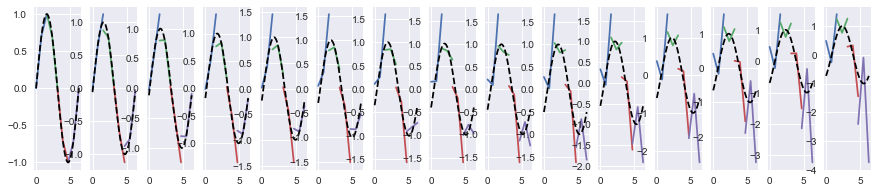

In [72]:
Nplots = 15
xx = np.linspace(0, 2*π, 100)

times = np.linspace(0, T, steps)
print(times[0], times[1], Δt)
assert np.isclose(times[1]-times[0], Δt)

fig = plt.figure(figsize=(Nplots,3))
for i in range(Nplots):
    u = solution[i,:,:]
    ax = fig.add_subplot(1, Nplots, i+1)
    ax = plot_solution(ax, u, dofh)
    ax.plot(xx, np.sin(xx - 2*π*times[i]), 'k--')

Exact solution $u = \sin(x - 2\pi t)$ implies that $\frac{d}{dx}(au) = a\frac{du}{dx} = a\cos(x - 2\pi t)$, so we can check the interior contribution.

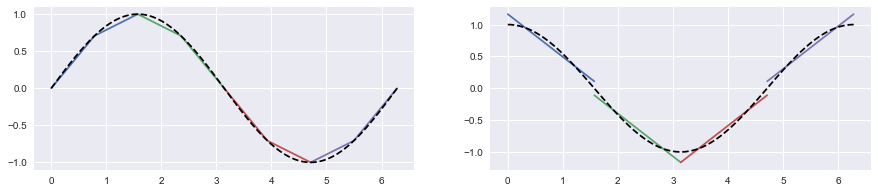

In [90]:
u0 = solution[0,::]
fig = plt.figure(figsize=(Nplots,3))

ax = fig.add_subplot(1, 2, 1)
ax = plot_solution(ax, u0, dofh)
ax.plot(xx, np.sin(xx - 2*π*times[0]), 'k--')

ax = fig.add_subplot(1, 2, 2)
dudx =  np.dot(master.Minv, np.dot(master.S, _map._detJ[0]*u0))
ax = plot_solution(ax, dudx, dofh)
ax.plot(xx, np.cos(xx - 2*π*times[0]), 'k--')
plt.show()

In [22]:
# Low storage Runge-Kutta coefficients LSERK
rk4a = np.array([
         0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0])

rk4b = np.array([ 
         1432997174477.0/9575080441755.0,
         5161836677717.0/13612068292357.0,
         1720146321549.0/2090206949498.0,
         3134564353537.0/4481467310338.0,
         2277821191437.0/14882151754819.0])

rk4c = np.array([
         0.0,
         1432997174477.0/9575080441755.0,
         2526269341429.0/6820363962896.0,
         2006345519317.0/3224310063776.0,
         2802321613138.0/2924317926251.0])

higher order RK4

```python
# time loop
print(solution.shape)
RK_resid = np.zeros_like(dofh.dgnodes)
for tstep in range(10):
    u = np.copy(solution[tstep, ::])
    print(u)
    for s in LSERK_stages:
        t_local = t + rk4c[s]*Δt
        rhsu = advect_rhs_1D(u, t_local, a, master, _map, dofh, flux_fn, gD, norm)
        RK_resid = rk4a[s]*RK_resid + Δt*rhsu
        u += rk4b[s]*RK_resid
    t += Δt
    tstep += 1
    solution[tstep, :,:] = u
```